# Replicable Clustering

Implementation and experiments for replicable clustering algorithm.

# Usage

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.dpi"] = 300.0

## Environment

### Mixture of Truncated Gaussians

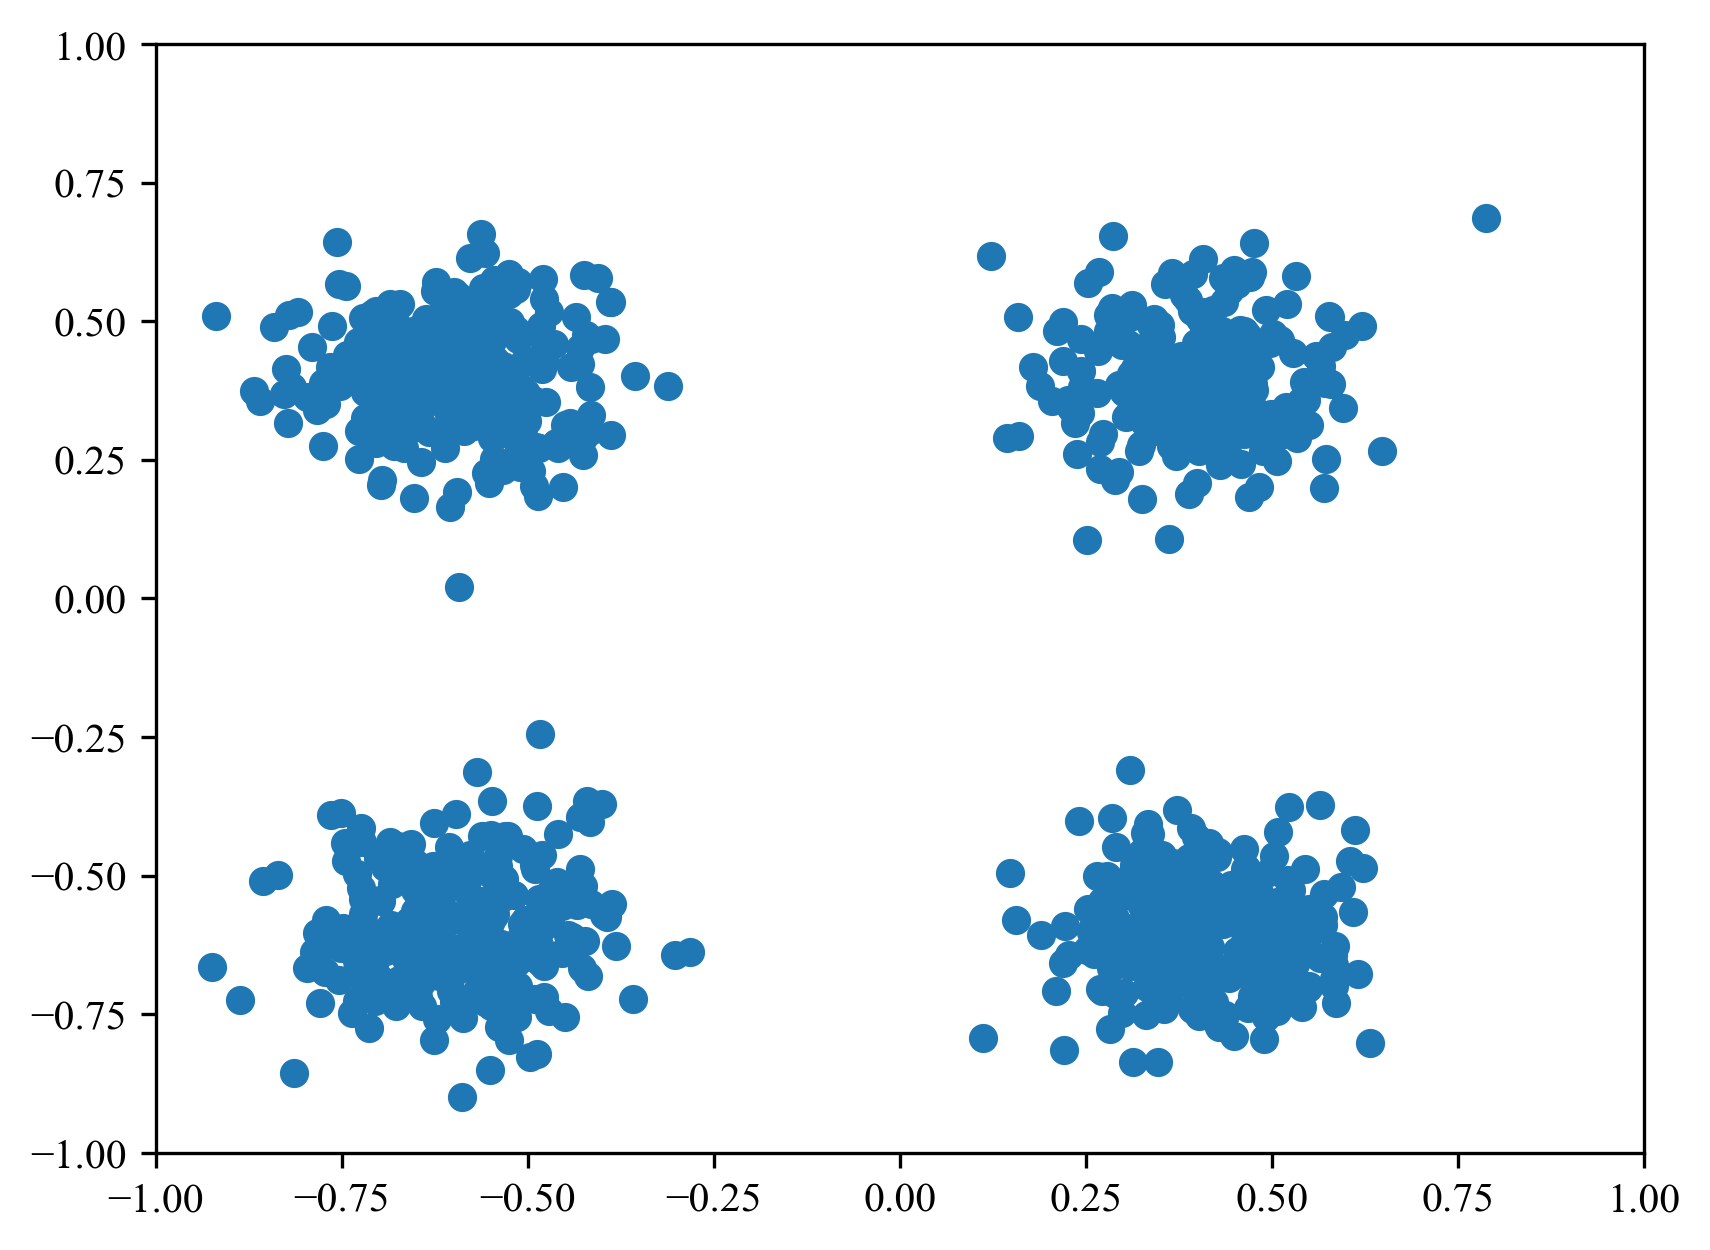

In [2]:
from plotting import plot2D
from samplers import MixtureTruncNormSampler

truncnorm_sampler = MixtureTruncNormSampler(0)  # external random seed
plot2D(truncnorm_sampler(1000))

### Two Moons Distribution

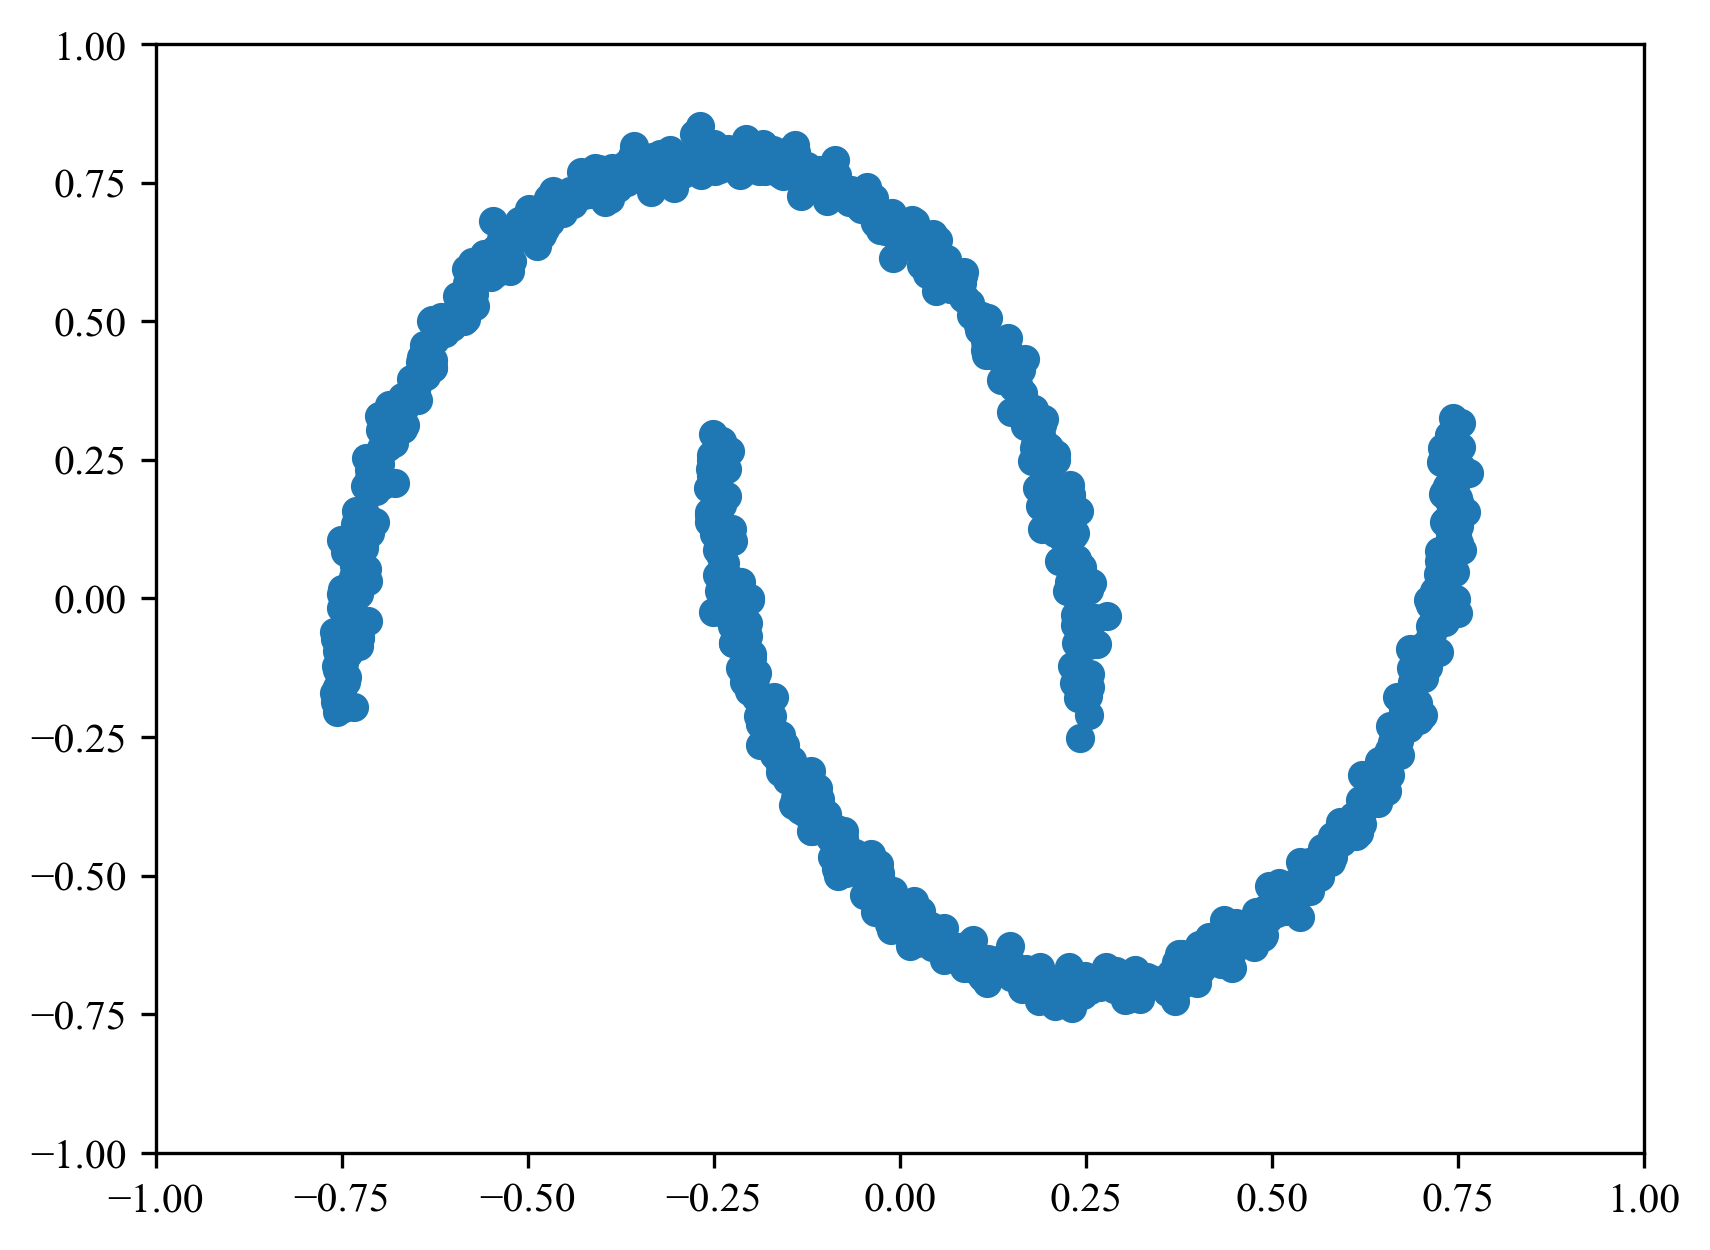

In [3]:
from samplers import MoonsSampler

moons_sampler = MoonsSampler(0)
plot2D(moons_sampler(1000))

## Replicable K-Means++

### Replicable Heavy Hitters

In [4]:
from heavy_hitters import r_heavy_hitters
from samplers import AbstractSampler


class ToySampler(AbstractSampler):
    def __call__(self, size: int) -> np.array:
        return self.random_state.choice(
            [0, 1, 2], p=[0.3, 0.3, 0.4], size=size
        ).reshape((-1, 1))


toy_sampler = ToySampler(16)

print(
    r_heavy_hitters(
        toy_sampler,
        thres=0.4,
        eps=0.1,
        rho=0.1,
        delta=0.01,
        random_state=2,
    )
)
print(
    r_heavy_hitters(
        toy_sampler,
        thres=0.4,
        eps=0.1,
        rho=0.1,
        delta=0.01,
        random_state=2,
    )
)

[[2]]
[[2]]


### Replicable Quad Tree

In [5]:
from quad_tree import r_quad_tree

root1 = r_quad_tree(
    truncnorm_sampler,
    k=3,
    eps=0.99,
    rho=0.4,
    delta=0.1,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=2,
)

root2 = r_quad_tree(
    truncnorm_sampler,
    k=3,
    eps=0.99,
    rho=0.4,
    delta=0.1,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=2,
)

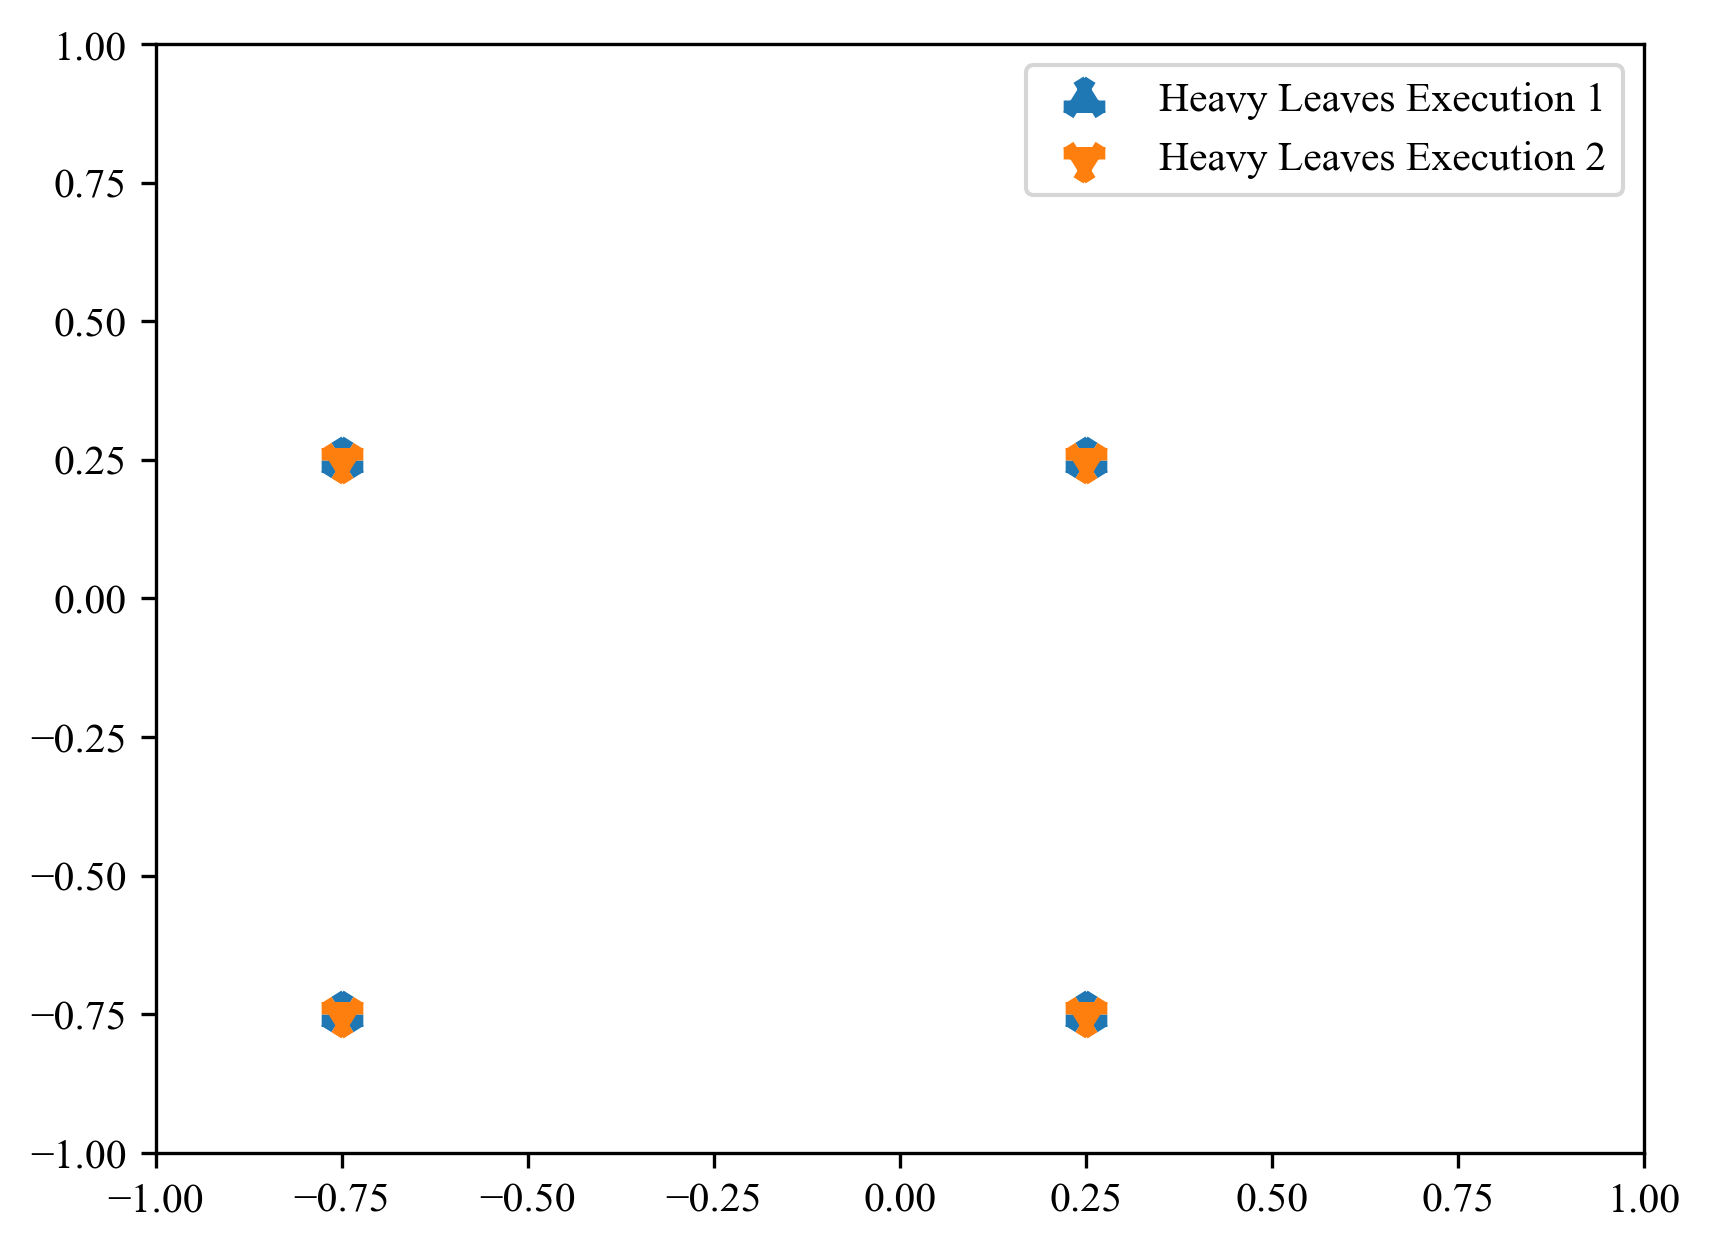

In [6]:
heavy_nodes1 = root1.get_leaves()
heavy_nodes2 = root2.get_leaves()

plot2D(
    heavy_nodes1,
    marker="1",
    linewidth=10,
    label="Heavy Leaves Execution 1",
)
plot2D(
    heavy_nodes1,
    marker="2",
    linewidth=10,
    label="Heavy Leaves Execution 2",
)

plt.legend()
plt.show()

### Replicable Probability Mass Estimation

In [7]:
from mass_estimation import r_prob_mass

samples1, mass1 = r_prob_mass(
    toy_sampler, N=3, rho=0.4, eps=0.01, delta=0.01, random_state=2
)
samples2, mass2 = r_prob_mass(
    toy_sampler, N=3, rho=0.4, eps=0.01, delta=0.01, random_state=2
)

assert np.isclose(mass1.sum(), 1.0)
assert np.isclose(mass2.sum(), 1.0)

print(samples1, mass1)
print(samples2, mass2)

[[0]
 [1]
 [2]] [0.29809856 0.30215553 0.39974591]
[[0]
 [1]
 [2]] [0.29809856 0.30215553 0.39974591]


### Replicable Coreset

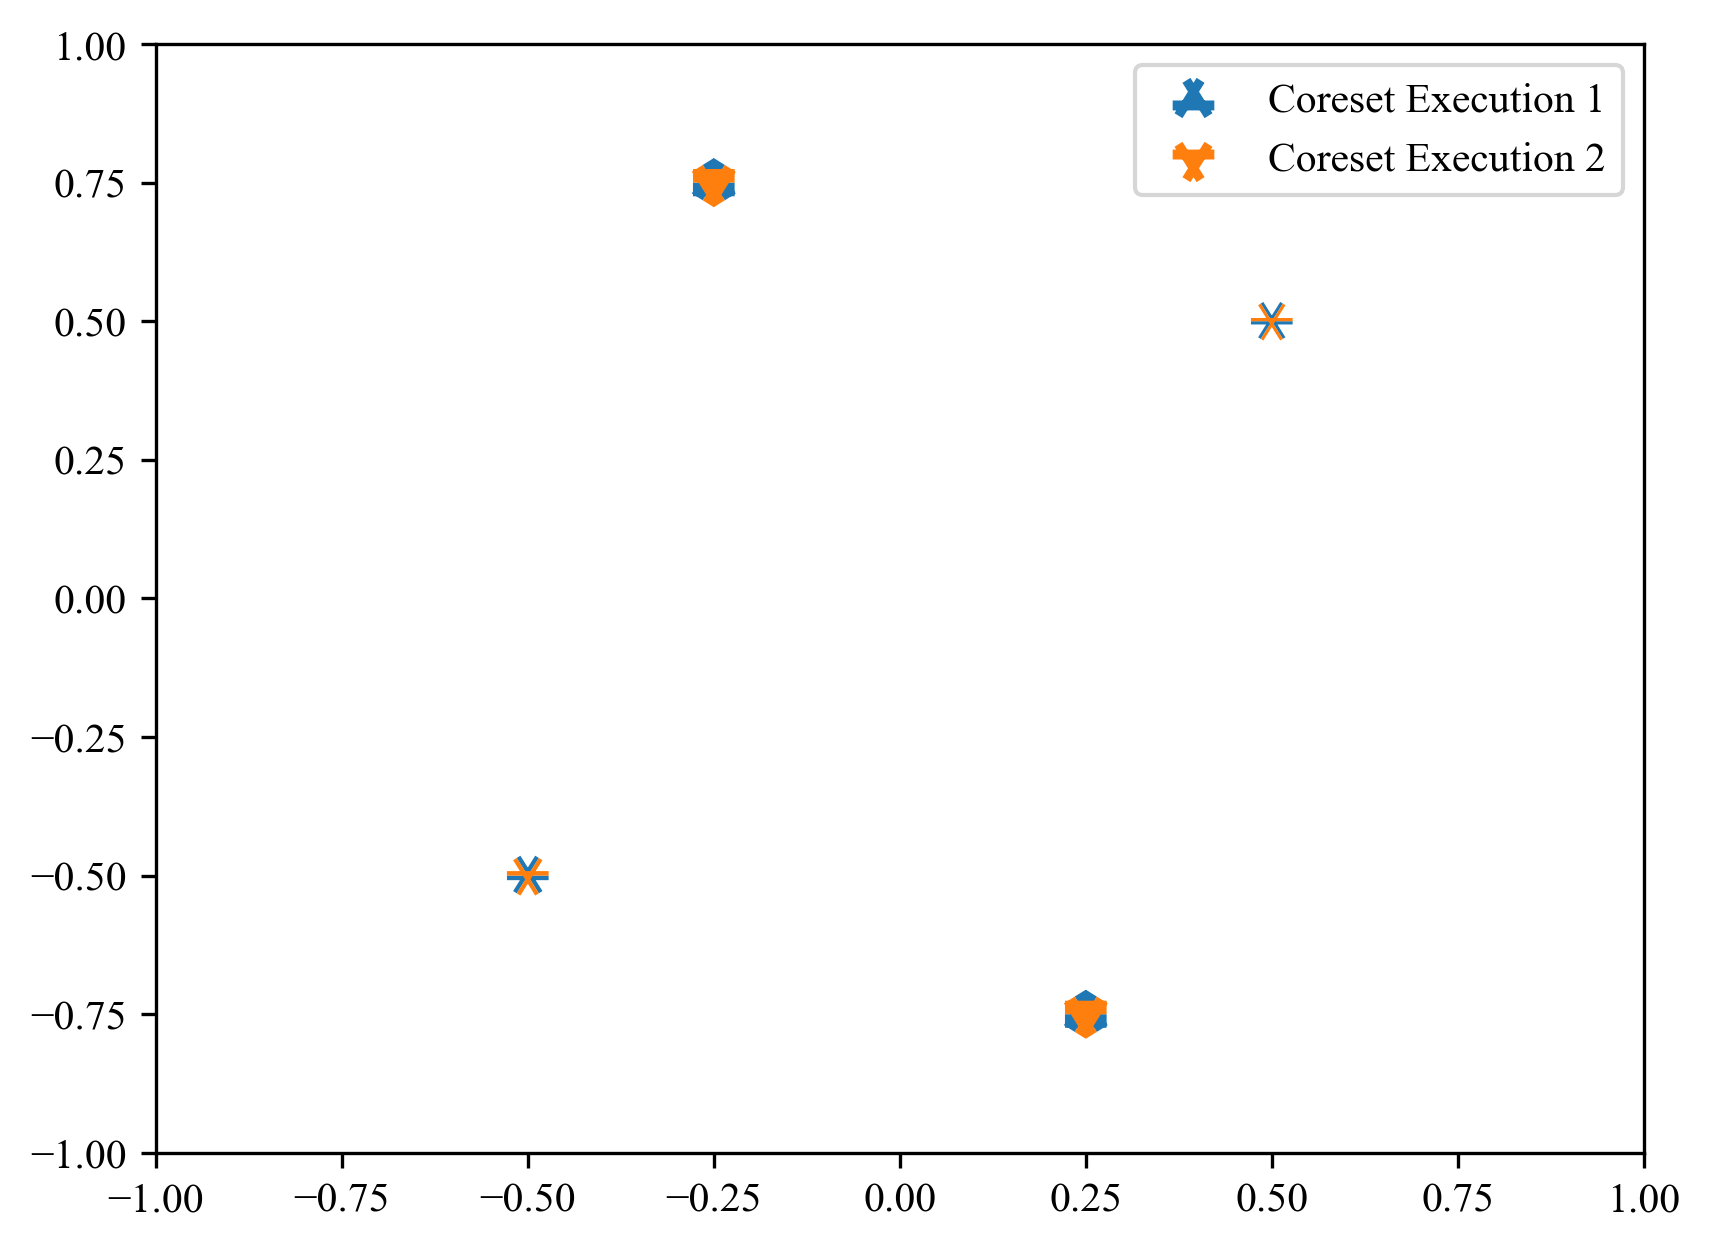

In [8]:
from coreset import r_coreset

coreset1, mass1 = r_coreset(
    moons_sampler,
    k=3,
    eps=0.99,
    rho=0.3,
    delta=0.01,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=2,  # shared internal random seed
)
coreset2, mass2 = r_coreset(
    moons_sampler,
    k=3,
    eps=0.99,
    rho=0.3,
    delta=0.01,
    Gamma=0.5,
    beta=1.0,
    Delta=np.sqrt(2),
    random_state=2,  # shared internal random seed
)

plot2D(
    coreset1,
    s=np.power(mass1, 3) * 1000,
    marker="1",
    linewidths=10,
    label="Coreset Execution 1",
)
plot2D(
    coreset2,
    s=np.power(mass2, 3) * 1000,
    marker="2",
    linewidths=10,
    label="Coreset Execution 2",
)

ax = plt.gca()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
plt.legend()
plt.show()

### Replicable K-Means++

/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

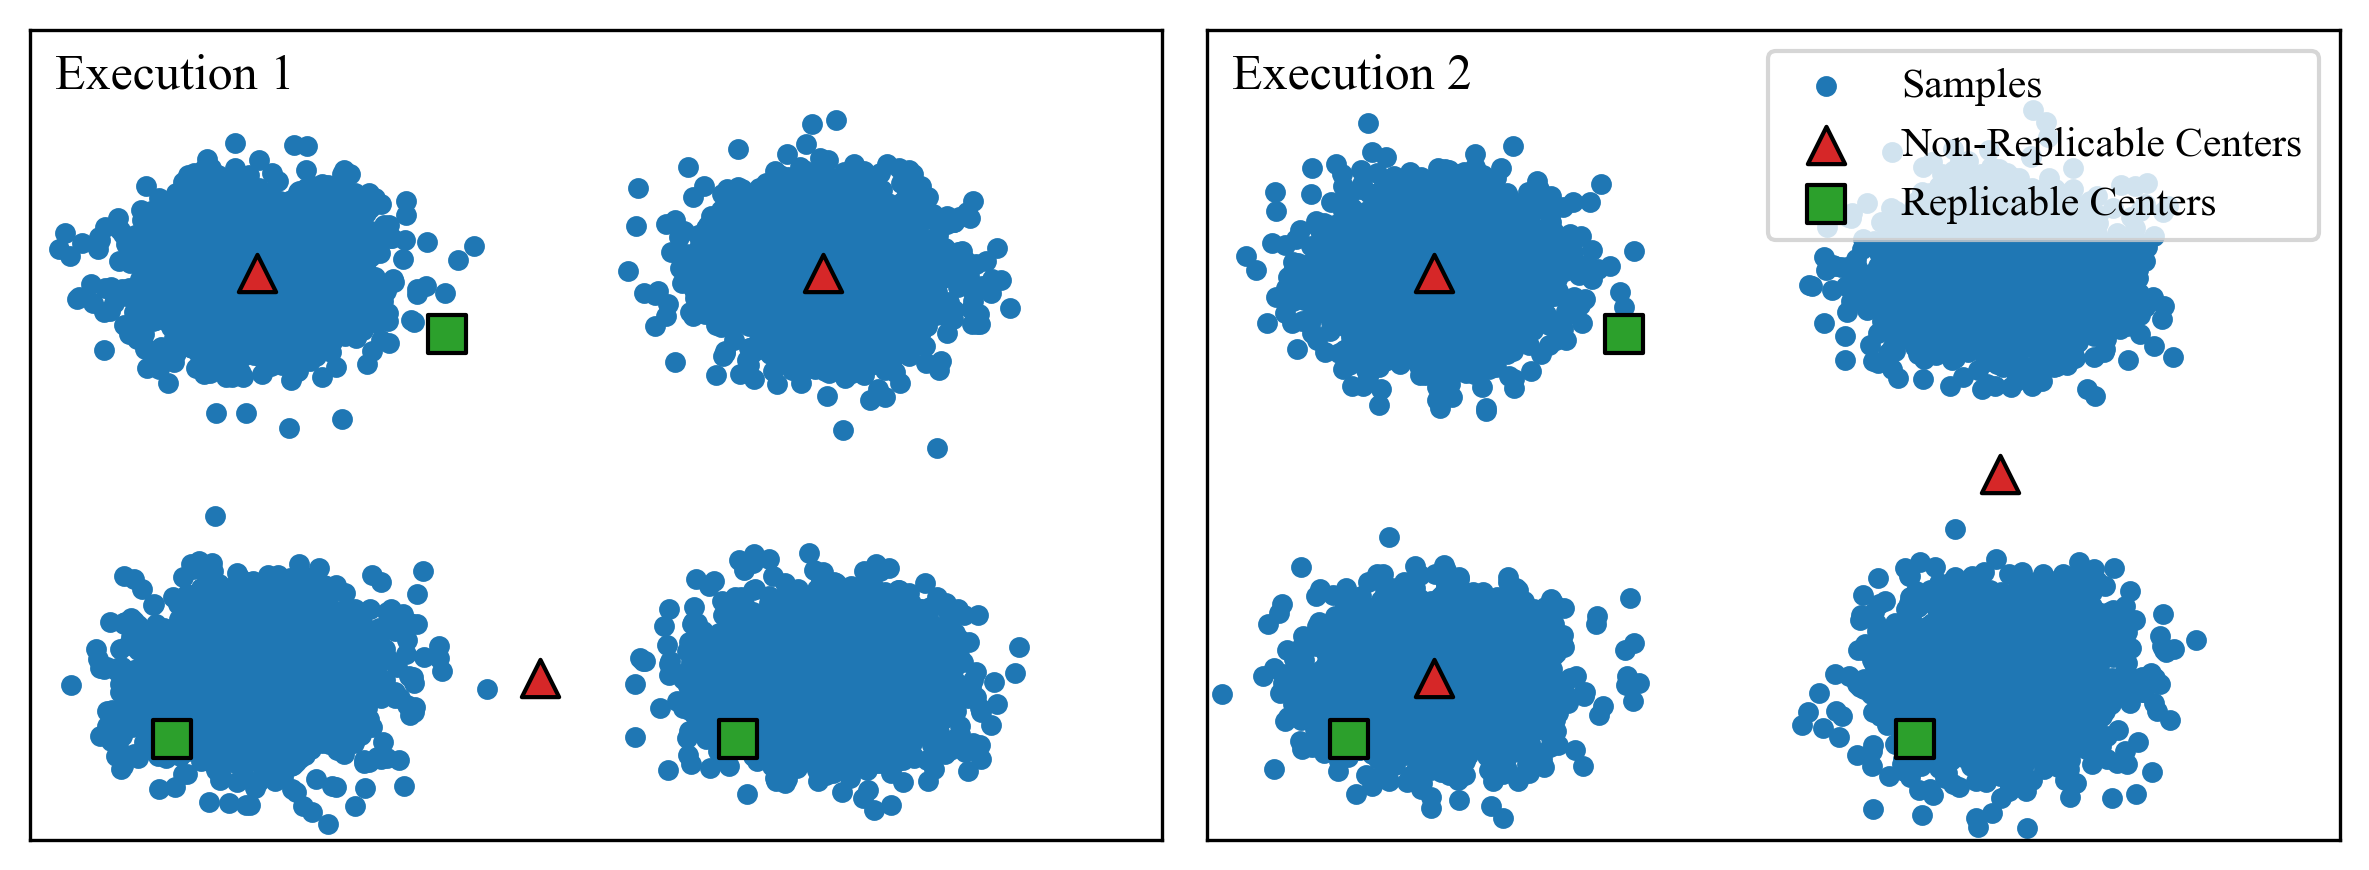

In [9]:
from plotting import compare_plot_kmeans

truncnorm_sampler = MixtureTruncNormSampler(12345)  # external random seed

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
compare_plot_kmeans(truncnorm_sampler, 2, fig, axes)

# fig.suptitle("Replicable K-Means++ on Truncated Gaussian Mixture")

fig.tight_layout()
plt.savefig("r_truncnorm.png", format="png", bbox_inches="tight", pad_inches=0)

plt.show()

/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/cz397/.mambaforge/envs/approx_matmul/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

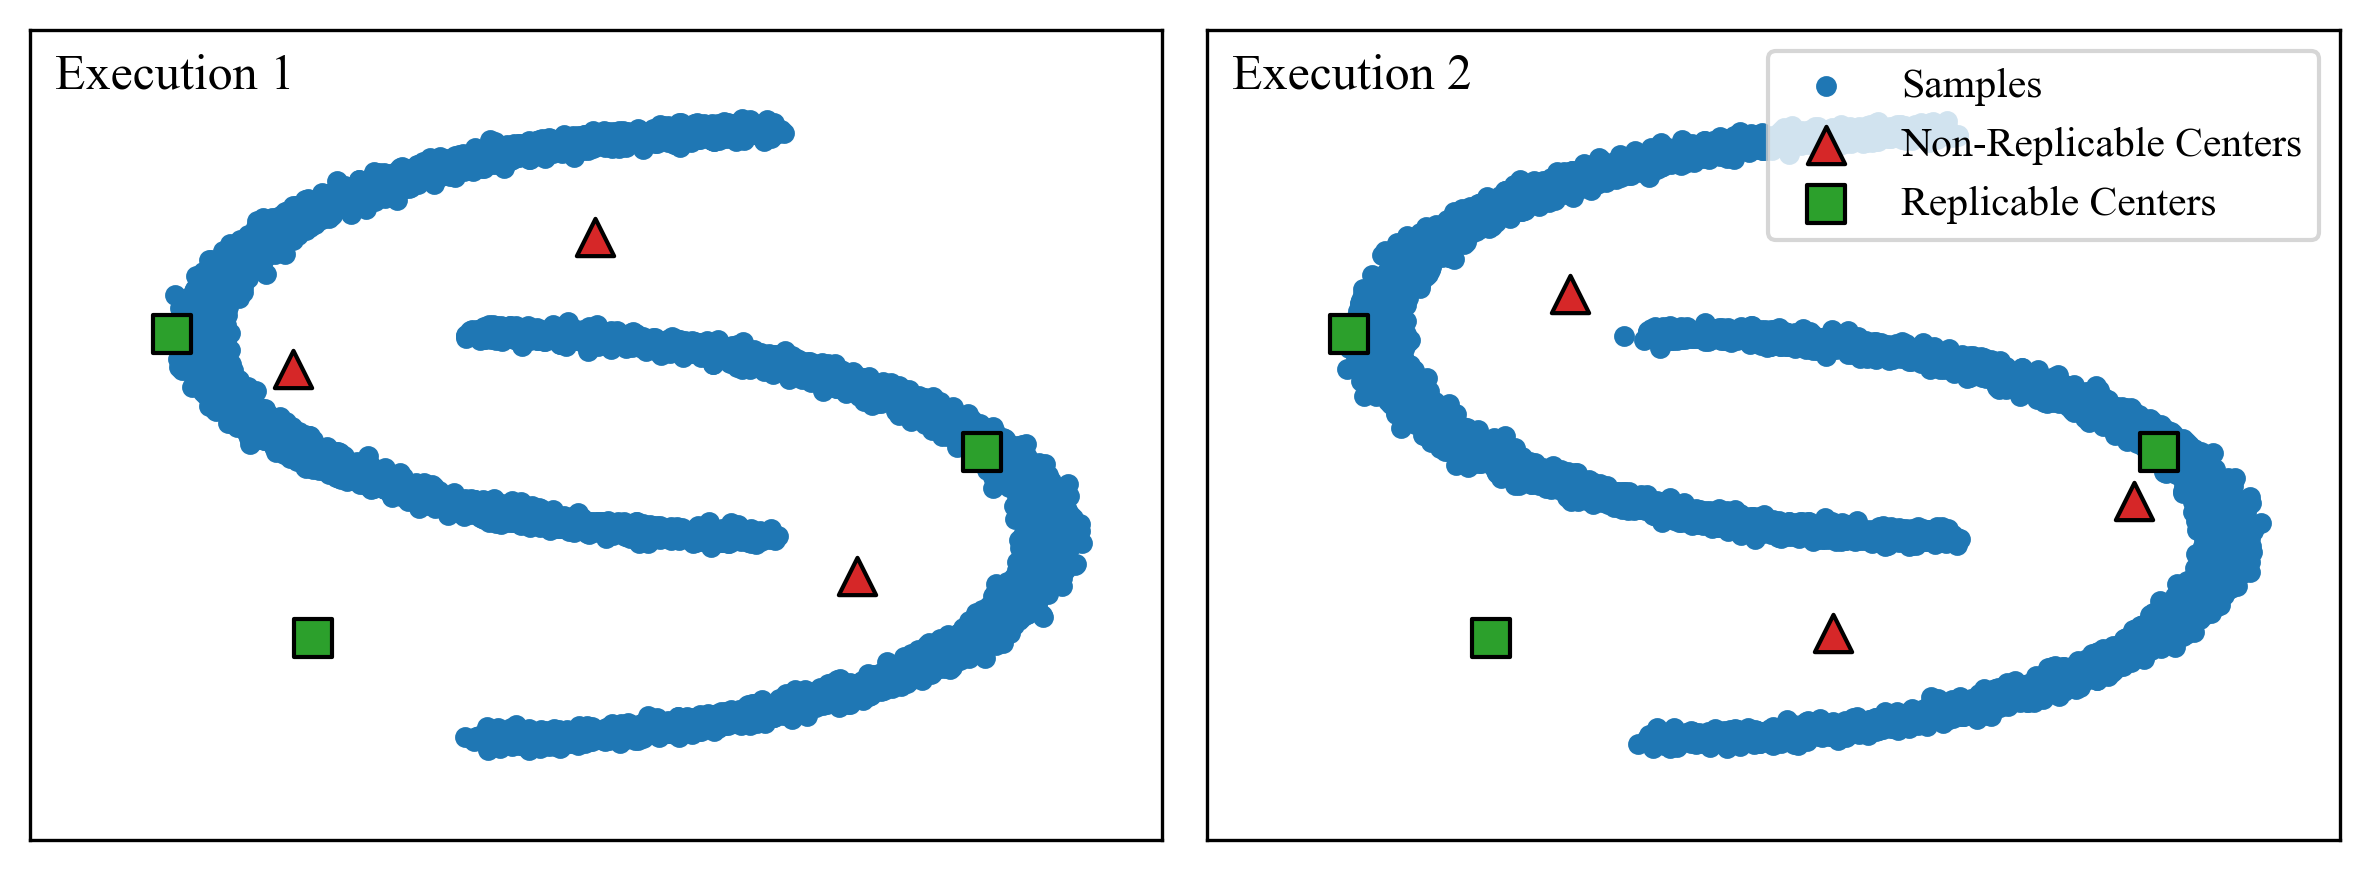

In [10]:
from plotting import compare_plot_kmeans

moons_sampler = MoonsSampler(54321)  # external random seed

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
compare_plot_kmeans(moons_sampler, 2, fig, axes)

# fig.suptitle("Replicable K-Means++ on Two Moons Distribution")

fig.tight_layout()
plt.savefig(
    "r_moons.png",
    format="png",
    # pil_kwargs={"cmap": "gray"},
    bbox_inches="tight",
    pad_inches=0,
)

plt.show()